In [ ]:
# !pip install kaggle
!pip install statsmodels 
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.3 MB/s 
     |████████████████████████████████| 9.8 MB 13.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c web-traffic-time-series-forecasting

 75% 51.0M/68.2M [00:00<00:00, 39.1MB/s]
100% 68.2M/68.2M [00:00<00:00, 78.0MB/s]
 93% 95.0M/102M [00:01<00:00, 56.5MB/s]
100% 102M/102M [00:01<00:00, 66.1MB/s] 
 97% 145M/150M [00:02<00:00, 64.5MB/s]
100% 150M/150M [00:02<00:00, 69.1MB/s]
 99% 65.0M/66.0M [00:01<00:00, 28.0MB/s]
100% 66.0M/66.0M [00:01<00:00, 48.8MB/s]
 87% 83.0M/96.0M [00:00<00:00, 129MB/s]
100% 96.0M/96.0M [00:00<00:00, 150MB/s]
 97% 98.0M/101M [00:01<00:00, 48.7MB/s]
100% 101M/101M [00:01<00:00, 65.3MB/s] 


In [ ]:
! unzip train_1.csv.zip
! unzip train_2.csv.zip

Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [ ]:
# Importing libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing train_1 consisting of 550 dates
train_1 = pd.read_csv('train_1.csv').fillna(0)
print(train_1.shape)
train_1.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
# Importing train_2 consisting of 803 dates for prediction
train_2 = pd.read_csv('train_2.csv').fillna(0)
print(train_2.shape)
train_2.head()

(145063, 804)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [ ]:
train1_main_df = pd.melt(train_1[list(train_1.columns[-550:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train1_main_df['Date'] = train1_main_df['Date'].astype('datetime64[ns]')
print(train1_main_df.shape)
train1_main_df.head()

(79784650, 3)


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [ ]:
train2_main_df = pd.melt(train_2[list(train_2.columns[-253:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train2_main_df['Date'] = train2_main_df['Date'].astype('datetime64[ns]')
print(train2_main_df.shape)
train2_main_df.head()

(36700939, 3)


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,26.0
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,27.0
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,13.0
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,12.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,8.0


Visualization

In [ ]:
# For visualization, consider just 100 dates
train1_df = pd.melt(train_1[list(train_1.columns[-100:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train1_df['Date'] = train1_df['Date'].astype('datetime64[ns]')
train1_df['Weekend'] = ((train1_df.Date.dt.dayofweek) // 5 == 1).astype(float)
print(train1_df.shape)
train1_df.head()

(14506300, 4)


,Page,Date,Visits,Weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-23,10.0,0.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-23,26.0,0.0
2,3C_zh.wikipedia.org_all-access_spider,2016-09-23,3.0,0.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-23,14.0,0.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-09-23,3.0,0.0


In [ ]:
# Median by page
median_df = pd.DataFrame(train1_df.groupby(['Page'])['Visits'].median())
median_df.columns = ['Median']

# Average by page
mean_df = pd.DataFrame(train1_df.groupby(['Page'])['Visits'].mean())
mean_df.columns = ['Mean']

# Merging data
train1_df = train1_df.set_index('Page').join(mean_df).join(median_df)
train1_df.reset_index(drop=False,inplace=True)

# Calculating WeekDay, Year, Month and Day columns
train1_df['Weekday'] = train1_df['Date'].apply(lambda x: x.weekday())
train1_df['Year'] = train1_df.Date.dt.year 
train1_df['Month'] = train1_df.Date.dt.month 
train1_df['Day'] = train1_df.Date.dt.day
print(train1_df.shape)
train1_df.head()

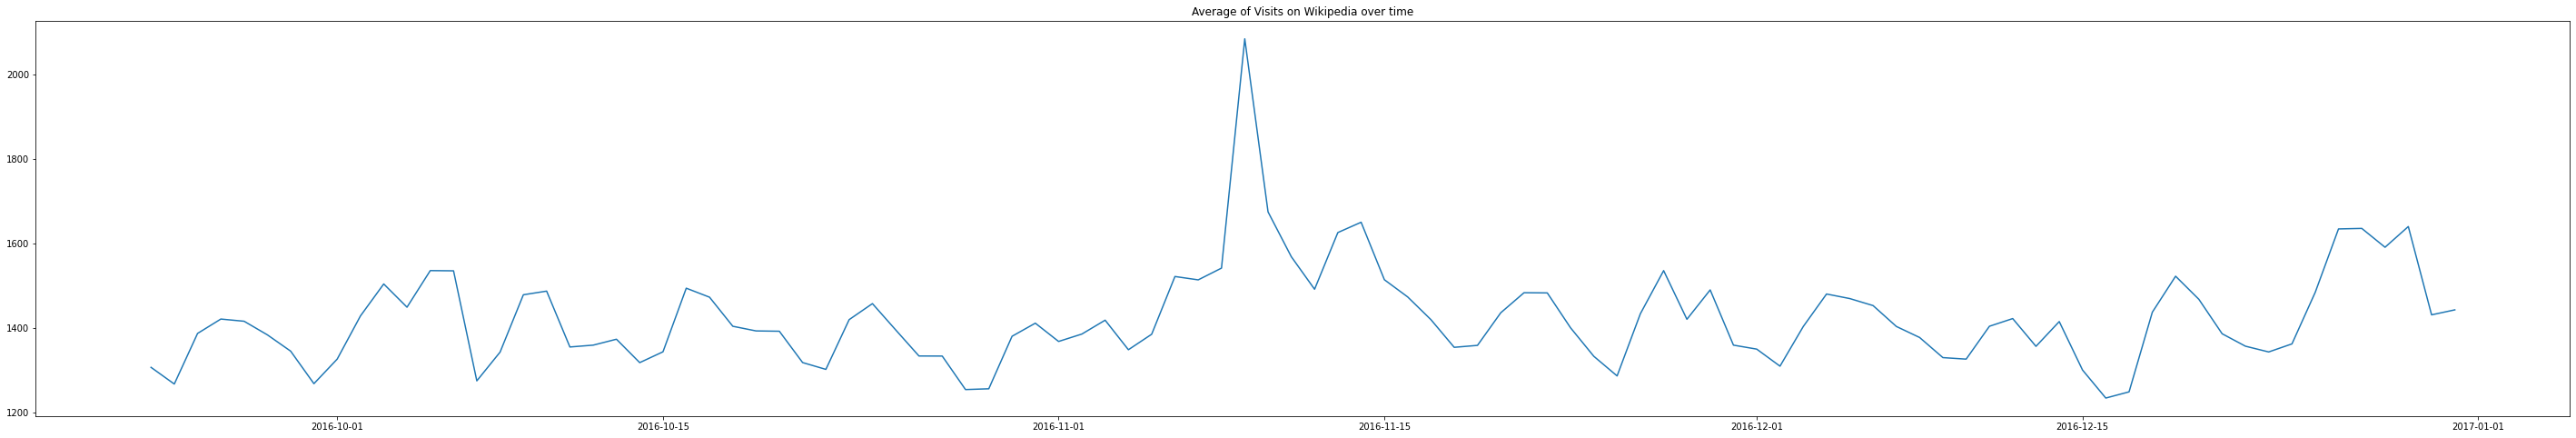

In [ ]:
plt.figure(figsize=(50, 8))
avg_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean()
plt.plot(avg_df)
plt.title('Average of Visits on Wikipedia over time')
plt.show()

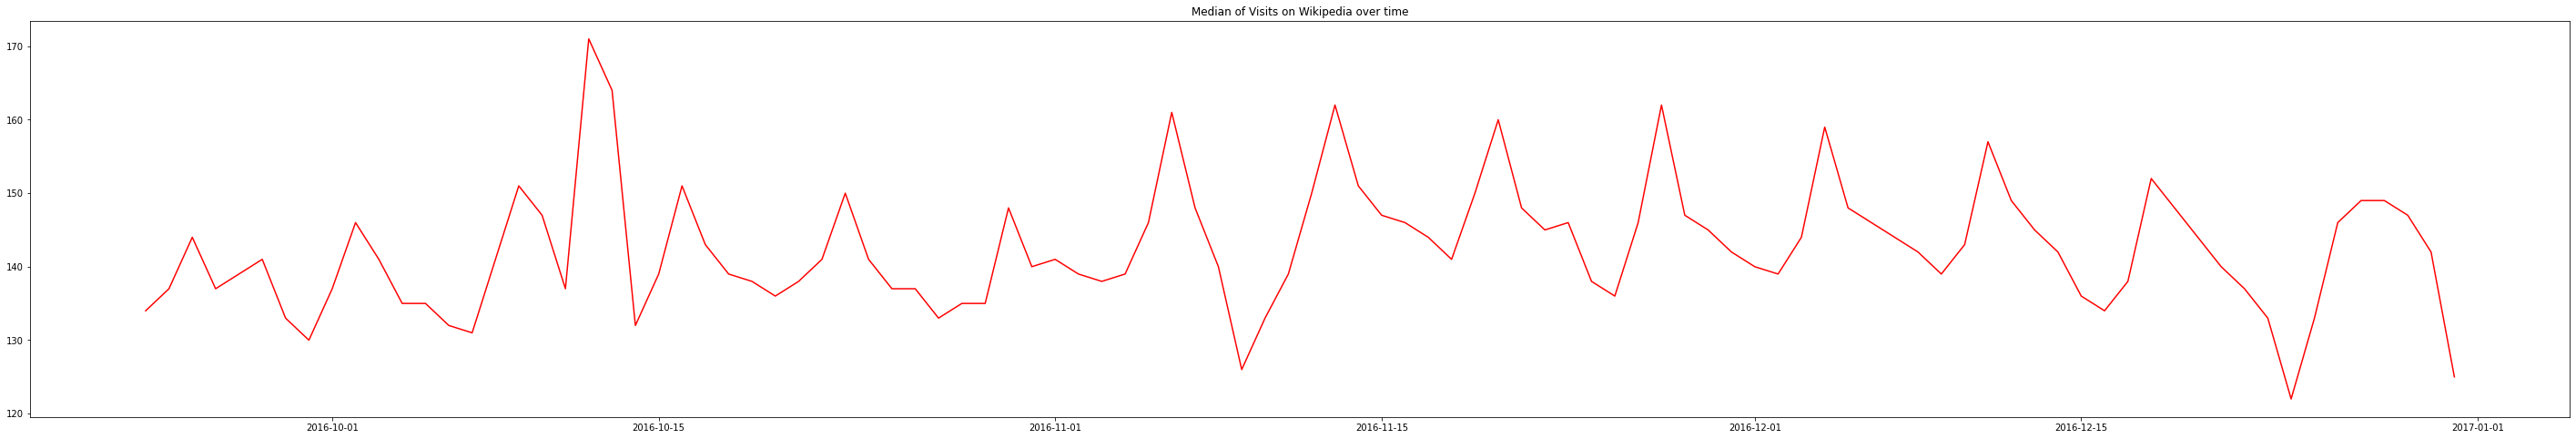

In [ ]:
plt.figure(figsize=(50, 8))
med_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].median()
plt.plot(med_df, color = 'r')
plt.title('Median of Visits on Wikipedia over time')
plt.show()

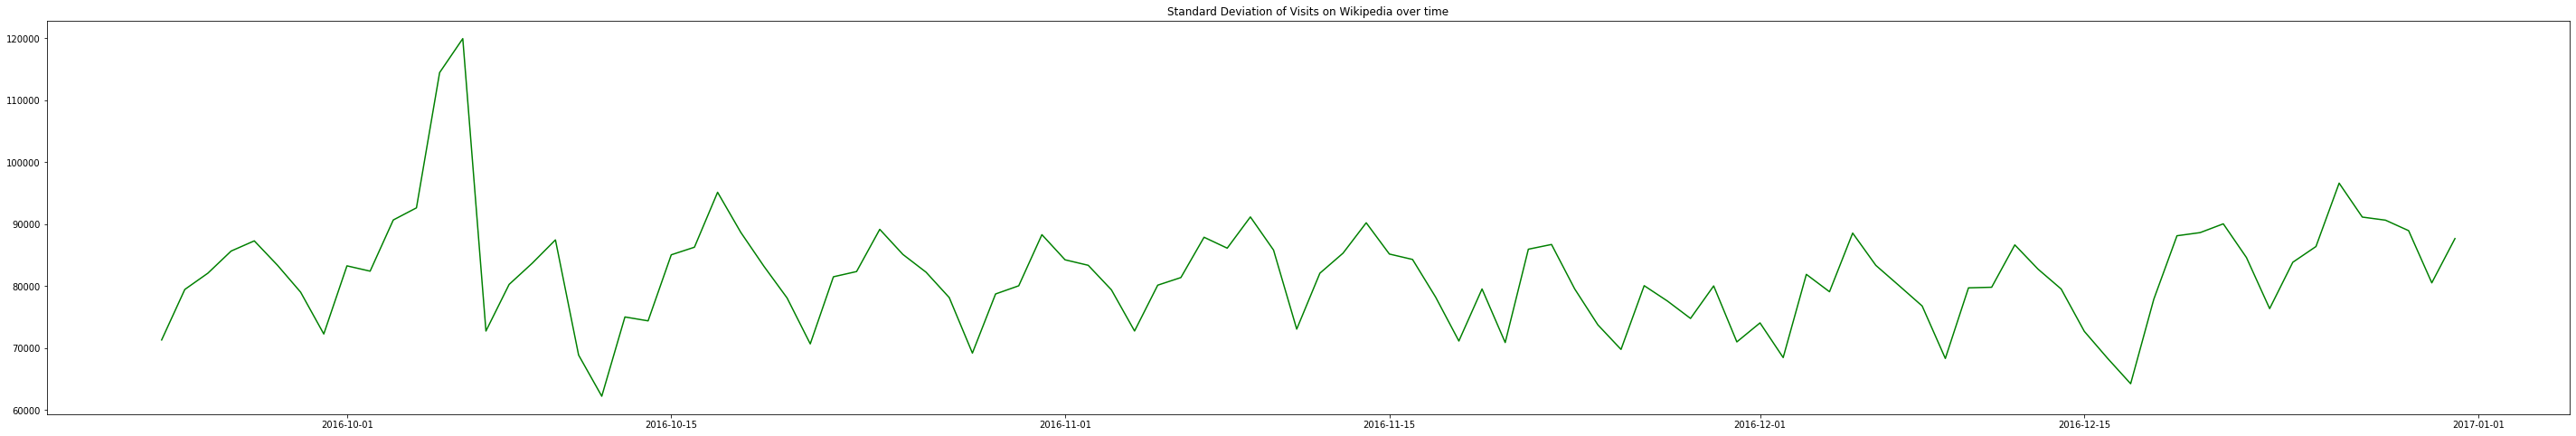

In [ ]:
plt.figure(figsize=(50, 8))
std_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].std()
plt.plot(std_df, color = 'g')
plt.title('Standard Deviation of Visits on Wikipedia over time')
plt.show()

In [ ]:
ts_data =  pd.DataFrame(avg_df).reset_index(drop=False)
ts_data['Weekday'] = ts_data['Date'].apply(lambda x: x.weekday())
ts_data['Date_str'] = ts_data['Date'].apply(lambda x: str(x))
ts_data[['Year','Month','Day']] = pd.DataFrame(ts_data['Date_str'].str.split('-',2).tolist(), columns = ['Year','Month','Day'])
date_staging = pd.DataFrame(ts_data['Day'].str.split(' ',2).tolist(), columns = ['Day','other'])
ts_data['Day'] = date_staging['Day']*1
ts_data.drop('Date_str',axis = 1, inplace =True)
print(ts_data.shape)
ts_data.head()

(100, 6)


,Date,Visits,Weekday,Year,Month,Day
0,2016-09-23,1307.048910,4,2016,09,23
1,2016-09-24,1267.586759,5,2016,09,24
2,2016-09-25,1387.193523,6,2016,09,25
3,2016-09-26,1421.203967,0,2016,09,26
4,2016-09-27,1416.020715,1,2016,09,27


Checking stationarity and seasonality

In [ ]:
ts1_final = train1_main_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean().reset_index(drop=False).set_index('Date')
ts2_final = train2_main_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean().reset_index(drop=False).set_index('Date')
# ts1_final = ts1.diff().dropna()
# ts2_final = ts2.diff().dropna()
print(ts1_final.shape, ts2_final.shape)
ts1_final.head()

(550, 1) (253, 1)


,Visits
Date,
2015-07-01,1024.882127
2015-07-02,1031.233602
2015-07-03,973.123388
2015-07-04,1003.791022
2015-07-05,1044.341920


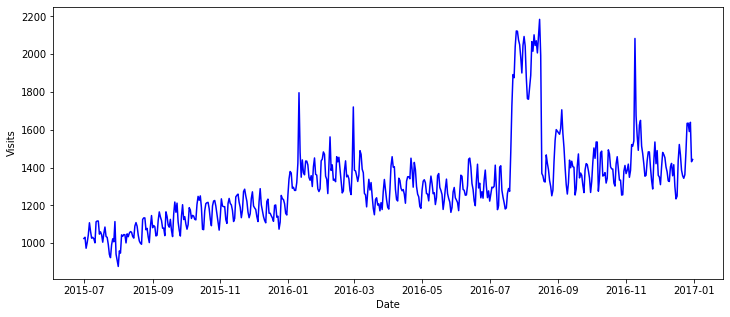

In [ ]:
# Plotting our train_1 timeseries data variation over time
plt.figure(figsize=(12, 5))
orig = plt.plot(ts1_final['Visits'], color='blue')
plt.ylabel('Visits')
plt.xlabel('Date')
plt.show(block=False)

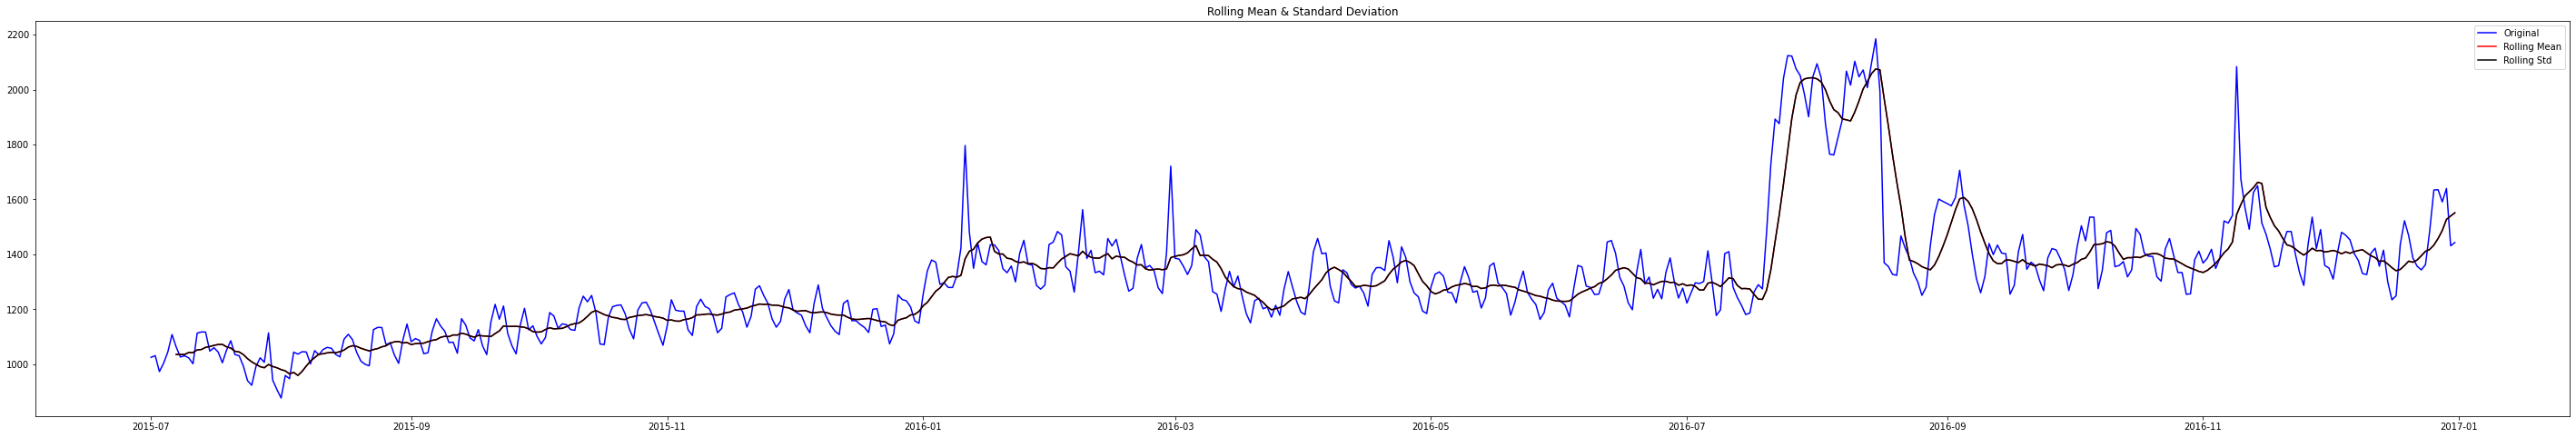

Results of Dickey-Fuller Test:
Test Statistic                  -2.436633
p-value                          0.131663
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


In [ ]:
# Show Rolling mean, Rolling standard deviation and Test for the stationarity
def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).mean()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(ts1_final.Visits)

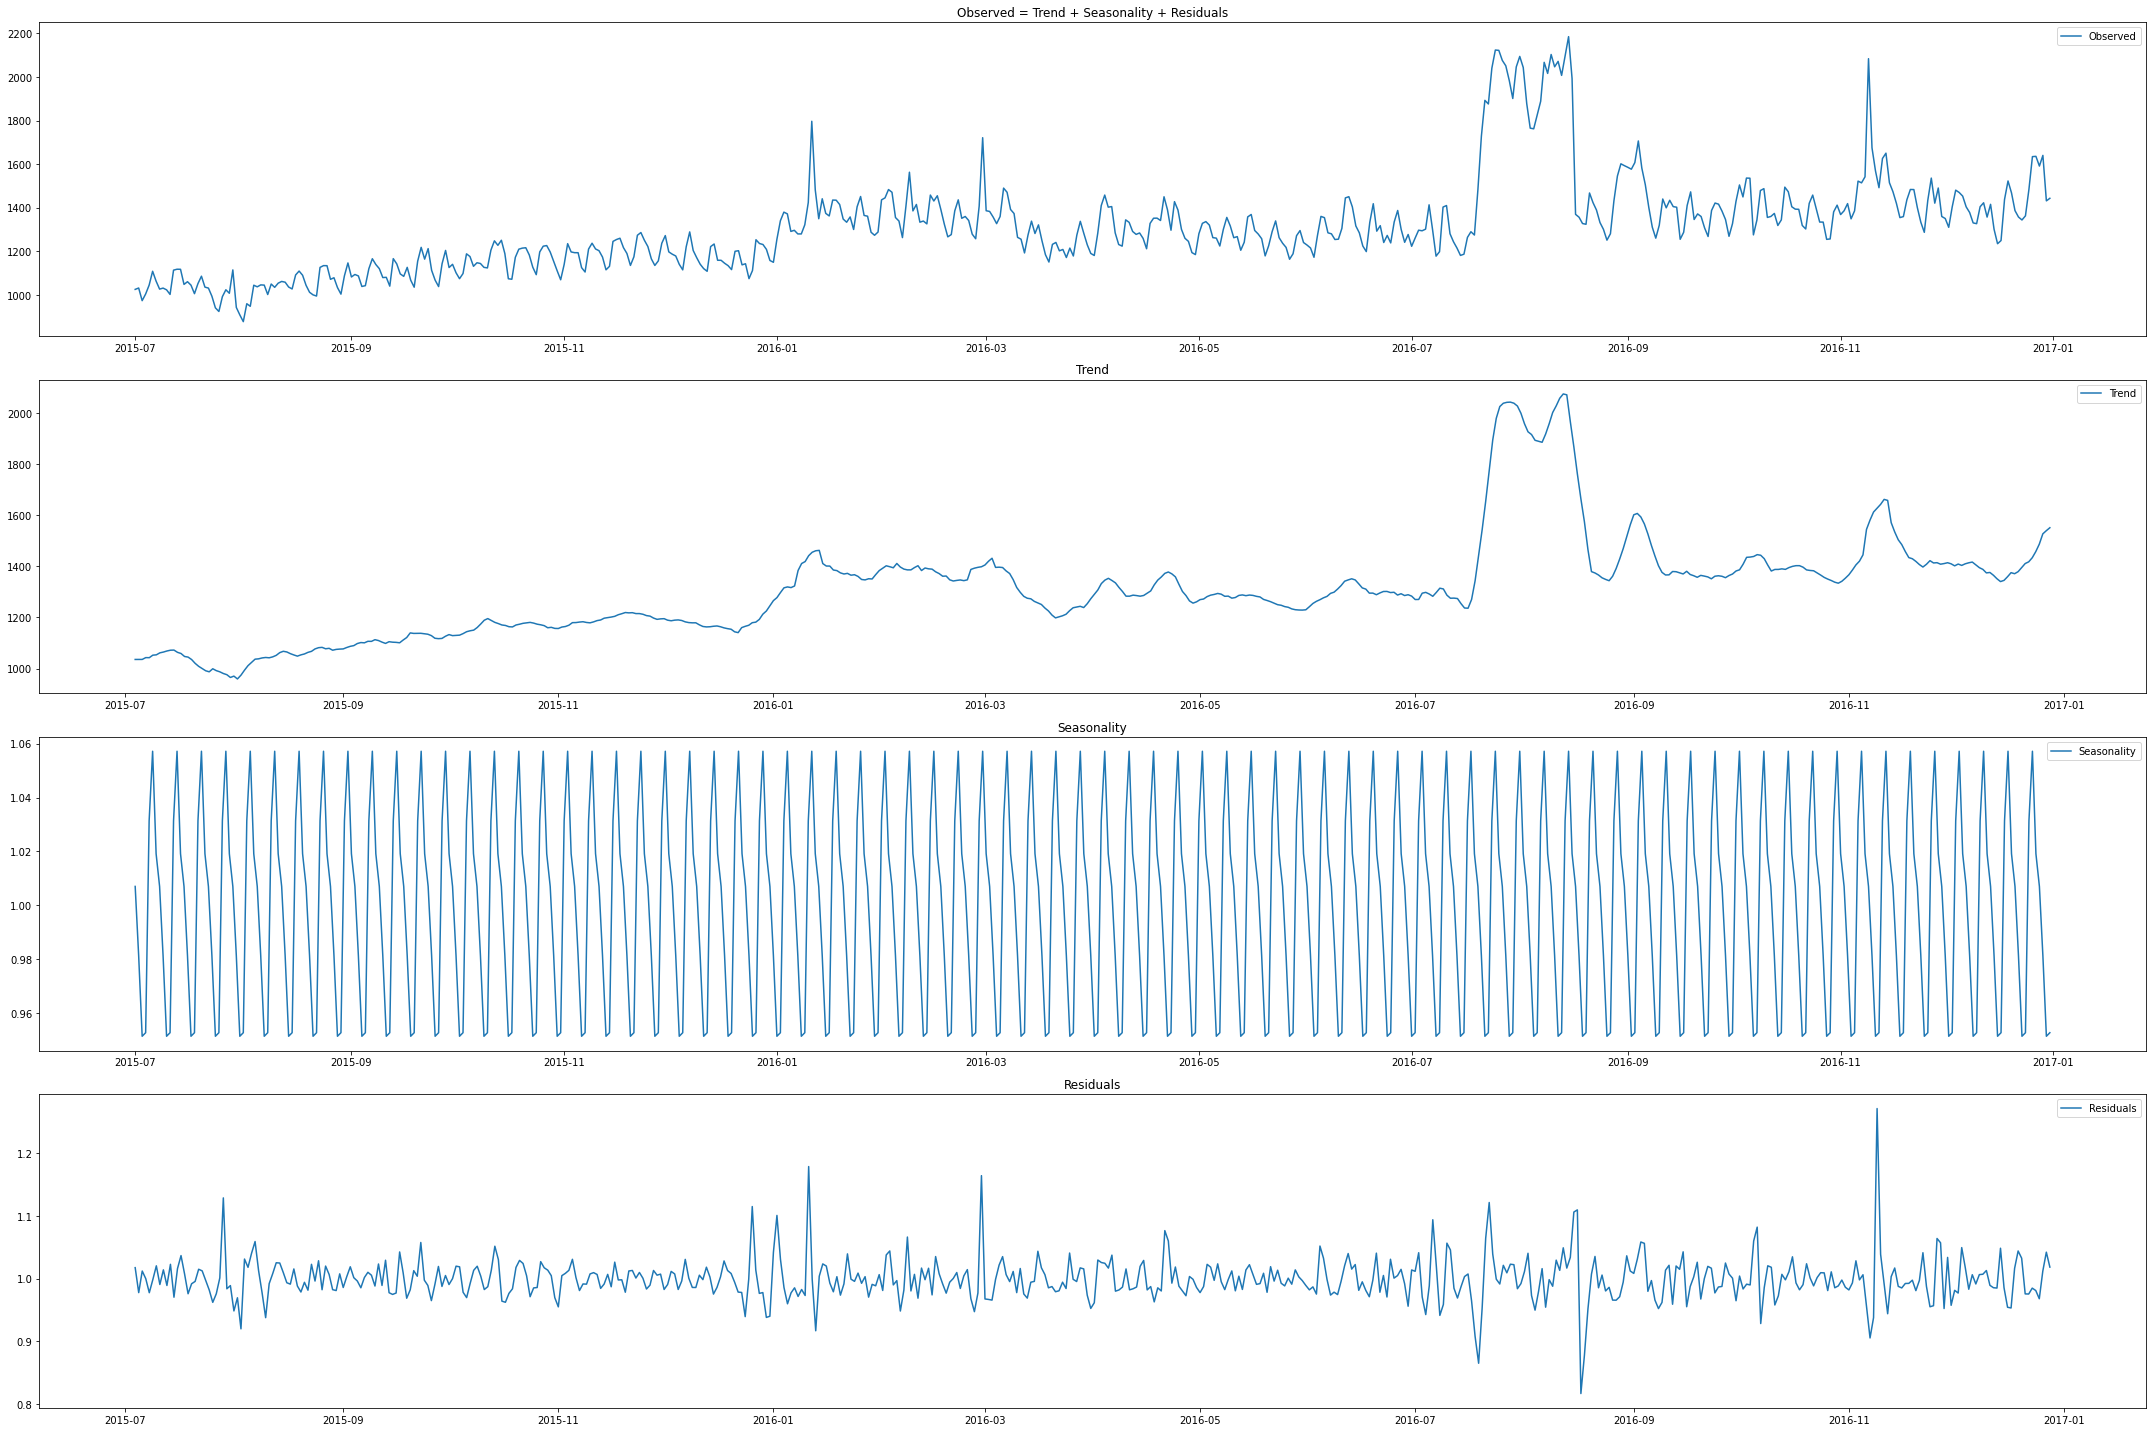

In [ ]:
def seasonal_decompose(timeseries):
  # Naive decomposition of the Time Series
  decomposition = sm.tsa.seasonal_decompose(ts1_final, model='multiplicative')

  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid
  rcParams['figure.figsize'] = 30, 20

  plt.subplot(411)
  plt.title('Observed = Trend + Seasonality + Residuals')
  plt.plot(ts1_final, label='Observed')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.title('Trend')
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.title('Seasonality')
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.title('Residuals')
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

seasonal_decompose(ts1_final)

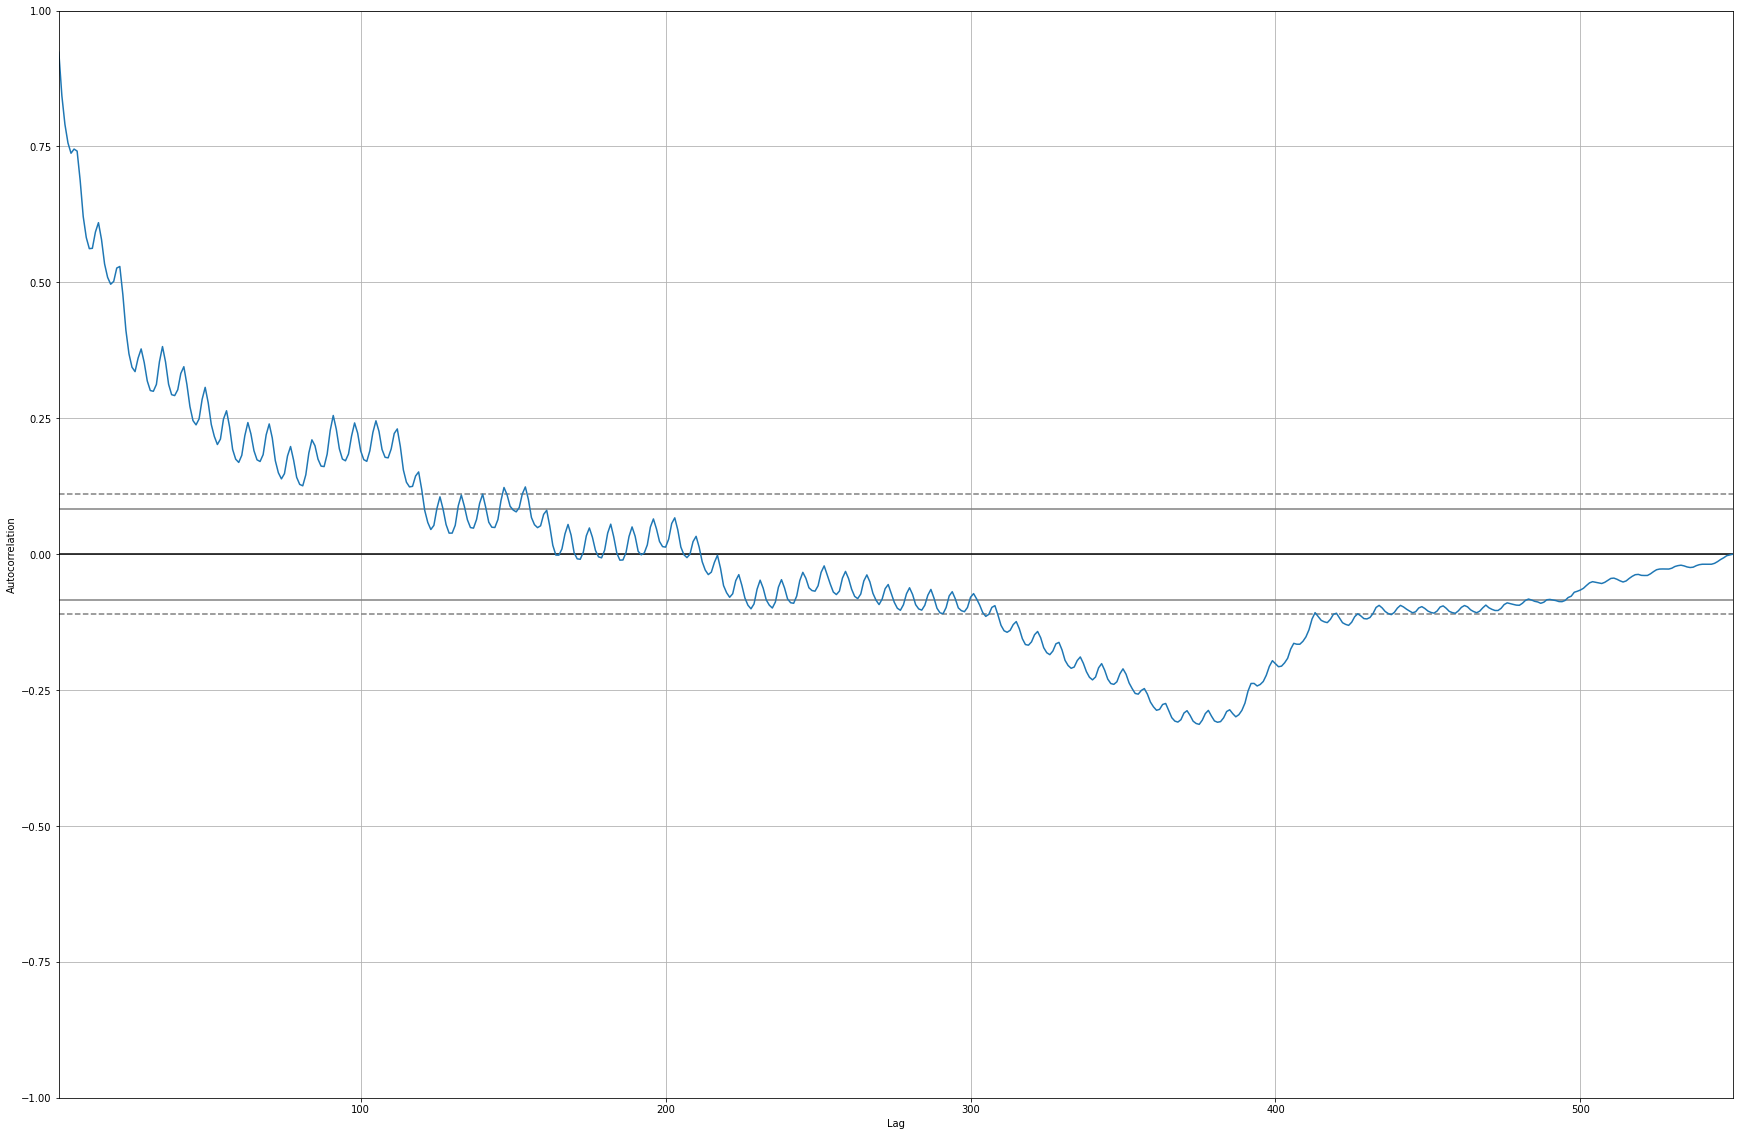

In [ ]:
# Auto Correlation Plot
pd.plotting.autocorrelation_plot(ts1_final['Visits'])

In [ ]:
# Augmented Dickey Fuller Test
def adf_test(dataset):
     test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",test[0])
     print("2. P-Value : ", test[1])
     print("3. Num Of Lags : ", test[2])
     print("4. Num Of Observations Used For ADF Regression:", test[3])
     print("5. Critical Values :")
     for key, val in test[4].items():
         print("\t",key, ": ", val)

adf_test(ts1_final['Visits'])

1. ADF :  -2.436632694929488
2. P-Value :  0.13166285090995383
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression: 535
5. Critical Values :
	 1% :  -3.4426321555520905
	 5% :  -2.86695748394138
	 10% :  -2.5696553279762426


Seasonality check

In [ ]:
seasonality_df = ts1_final.copy()
seasonality_df['first_diff'] = seasonality_df.Visits - seasonality_df.Visits.shift(1)
adf_test(seasonality_df.first_diff.dropna(inplace=False))
seasonality_df.head()

1. ADF :  -7.893704903540242
2. P-Value :  4.367449082413145e-12
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression: 535
5. Critical Values :
	 1% :  -3.4426321555520905
	 5% :  -2.86695748394138
	 10% :  -2.5696553279762426


,Visits,first_diff
Date,,
2015-07-01,1024.882127,NaN
2015-07-02,1031.233602,6.351475
2015-07-03,973.123388,-58.110214
2015-07-04,1003.791022,30.667634
2015-07-05,1044.341920,40.550899


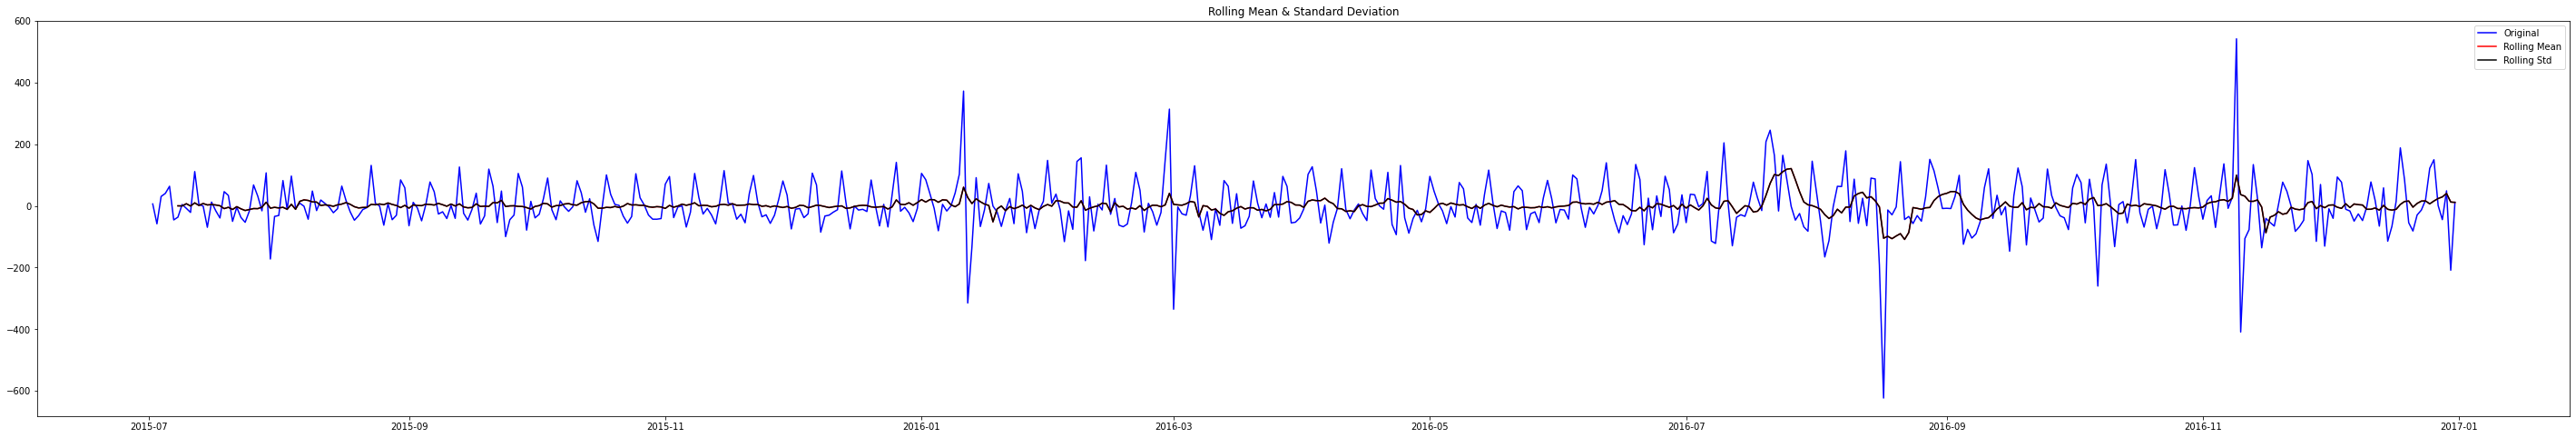

Results of Dickey-Fuller Test:
Test Statistic                -7.893705e+00
p-value                        4.367449e-12
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.442632e+00
Critical Value (5%)           -2.866957e+00
Critical Value (10%)          -2.569655e+00
dtype: float64


,Visits
Date,
2015-07-02,6.351475
2015-07-03,-58.110214
2015-07-04,30.667634
2015-07-05,40.550899
2015-07-06,63.743767


In [ ]:
# After differencing the data
ts1_final = seasonality_df.drop(['Visits'], axis=1).rename(columns={"first_diff":"Visits"}).dropna()
test_stationarity(ts1_final.Visits)
ts1_final.head()

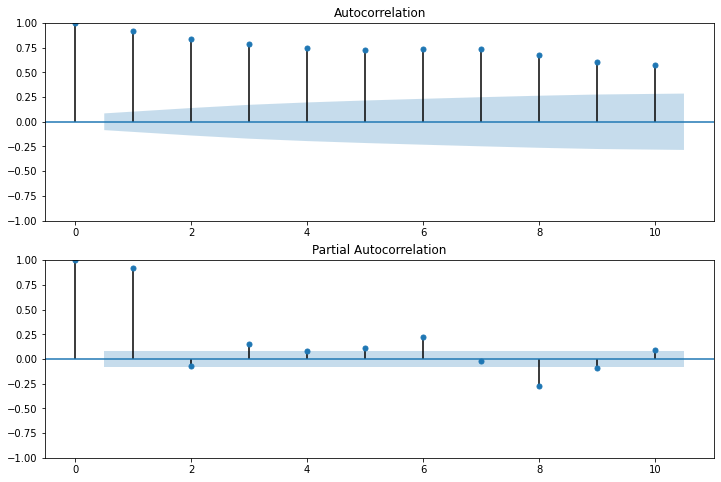

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts1_final.Visits.iloc[13:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts1_final.Visits.iloc[13:], lags=10, ax=ax2)

Auto Arima



In [ ]:
from pmdarima import auto_arima

auto_arima = auto_arima(ts1_final.Visits, 
                        test='adf',
                        d=1, 
                        D=1, 
                        trace=True, 
                        error_action='ignore', 
                        suppress_warnings=True, 
                        stepwise=True)
print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6785.447, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6698.431, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6783.447, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6626.122, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6592.637, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6581.547, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6515.859, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6513.861, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6579.549, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.45 s

ARIMA Modelling

In [ ]:
train, test = ts1_final.iloc[:-50], ts1_final.iloc[-50:]
# train, test = ts1_final, ts2_final[-253:]
print(train.shape, test.shape)
test.head()

(499, 1) (50, 1)


,Visits
Date,
2016-11-12,-76.970482
2016-11-13,134.036336
2016-11-14,24.398413
2016-11-15,-135.909777
2016-11-16,-40.629147


In [ ]:
# Give order value based on above results
model = ARIMA(train.Visits, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  499
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2948.439
Date:                Fri, 10 Dec 2021   AIC                           5908.878
Time:                        20:50:47   BIC                           5934.142
Sample:                    07-02-2015   HQIC                          5918.793
                         - 11-11-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7080      0.023    -30.232      0.000      -0.754      -0.662
ar.L2         -0.7125      0.047    -15.192      0.000      -0.804      -0.621
ar.L3         -0.5338      0.048    -11.013      0.0

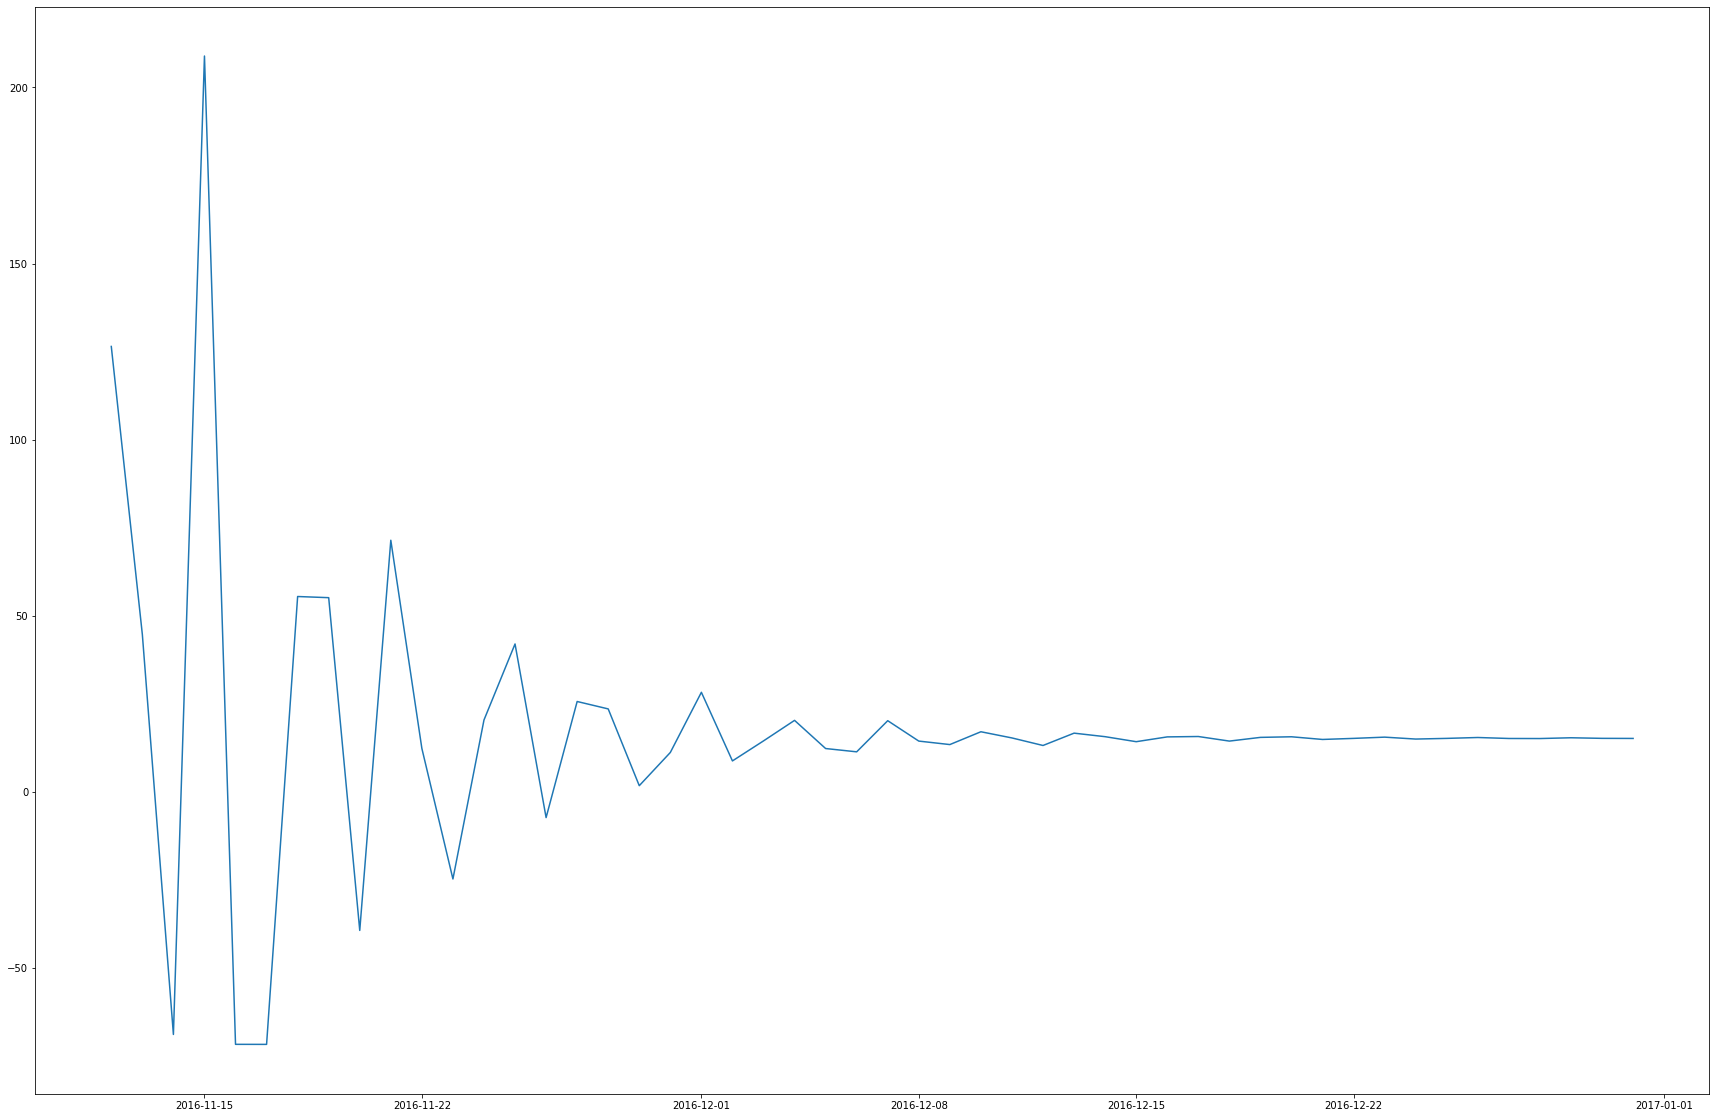

In [ ]:
# Plot predicted values
predicted = model_fit.forecast(50)
plt.plot(predicted)
#plt.plot(train.Visits)

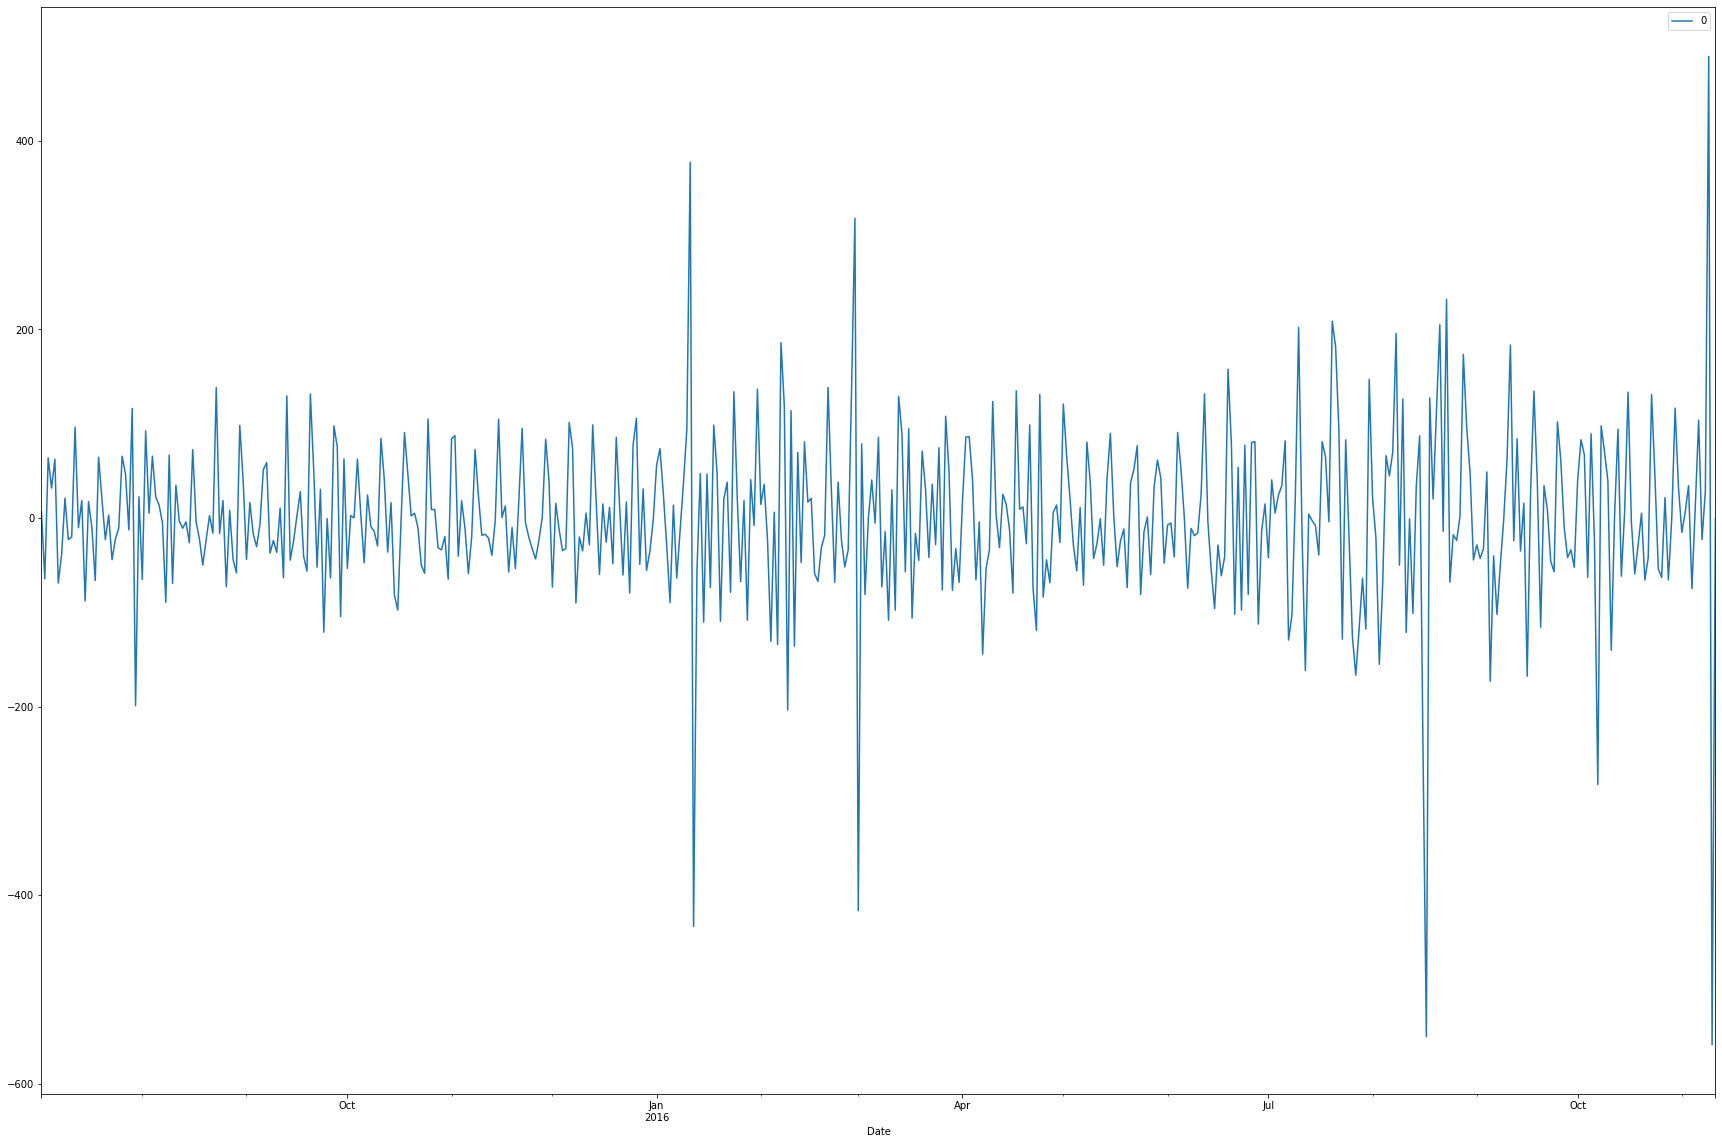

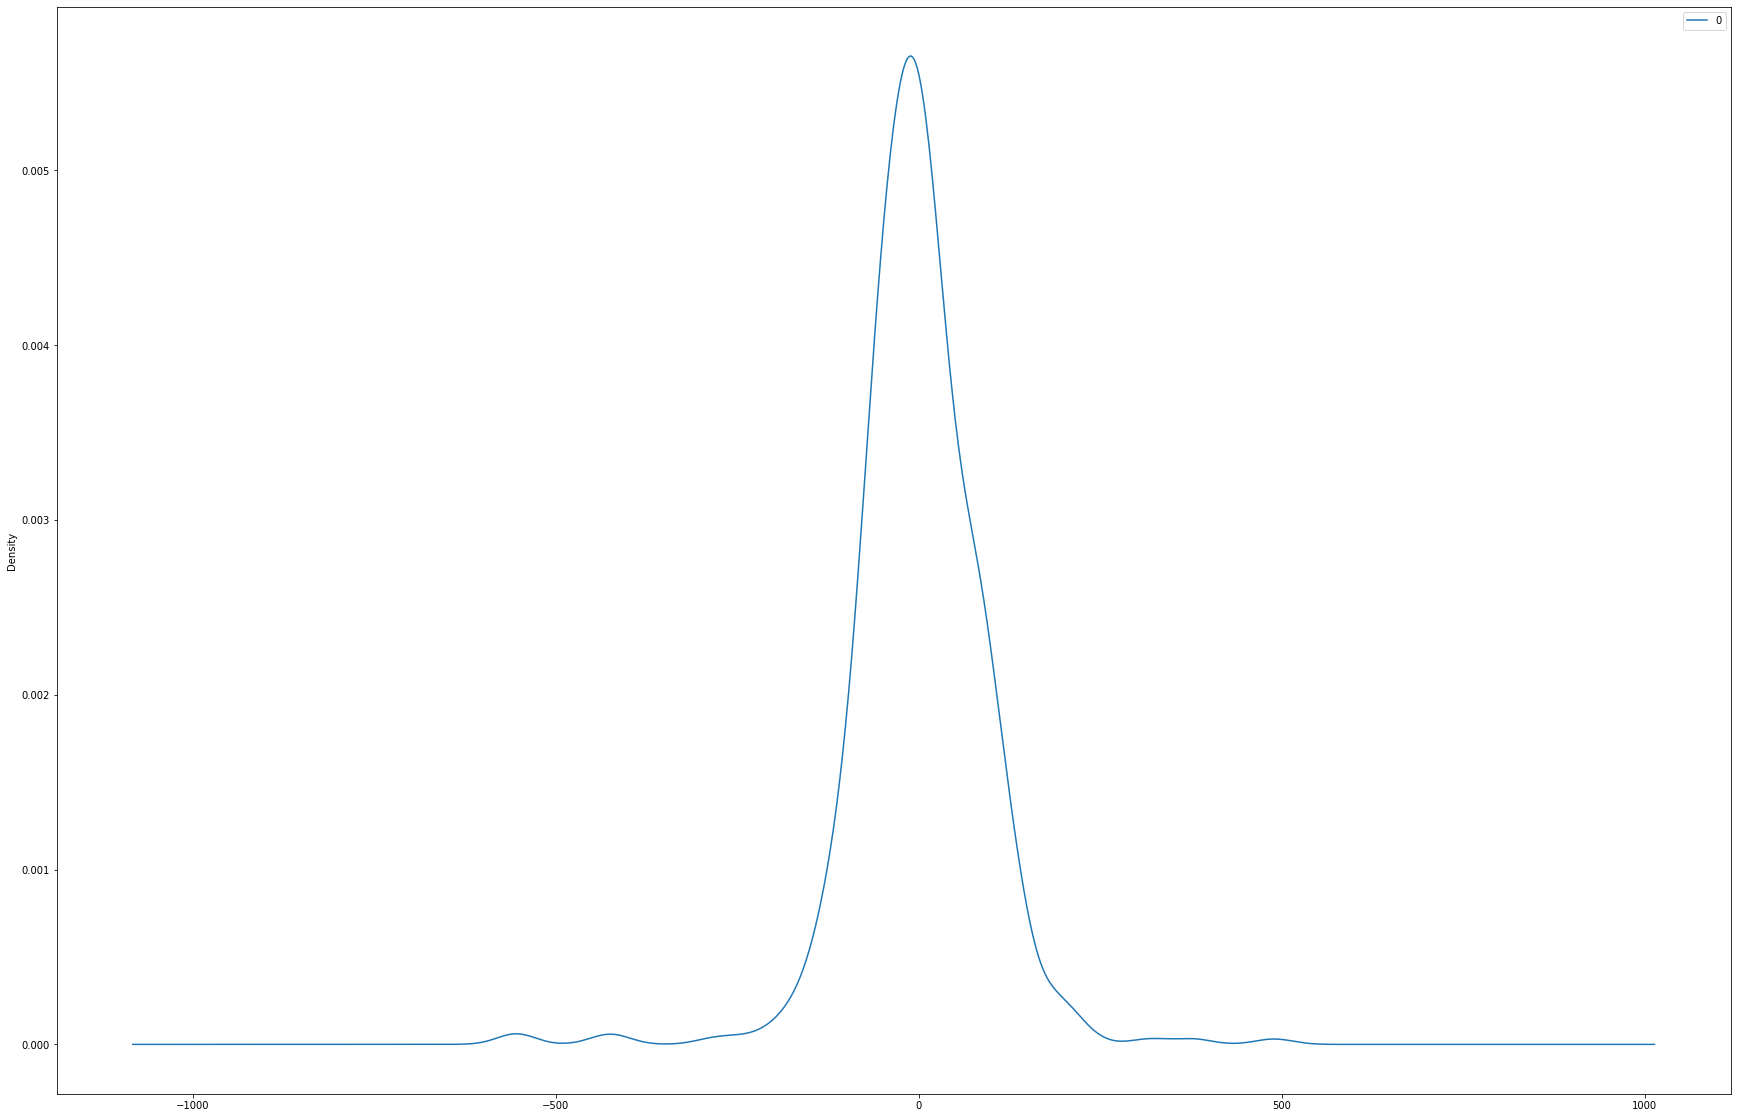

                0
count  499.000000
mean     0.124408
std     90.072481
min   -558.610204
25%    -44.848452
50%     -2.665816
75%     46.671259
max    489.550528


In [ ]:
plt.plot(train, color = 'blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.show()
# Residual plot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()
# Summary of residuals
print(residuals.describe())

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)

499 548


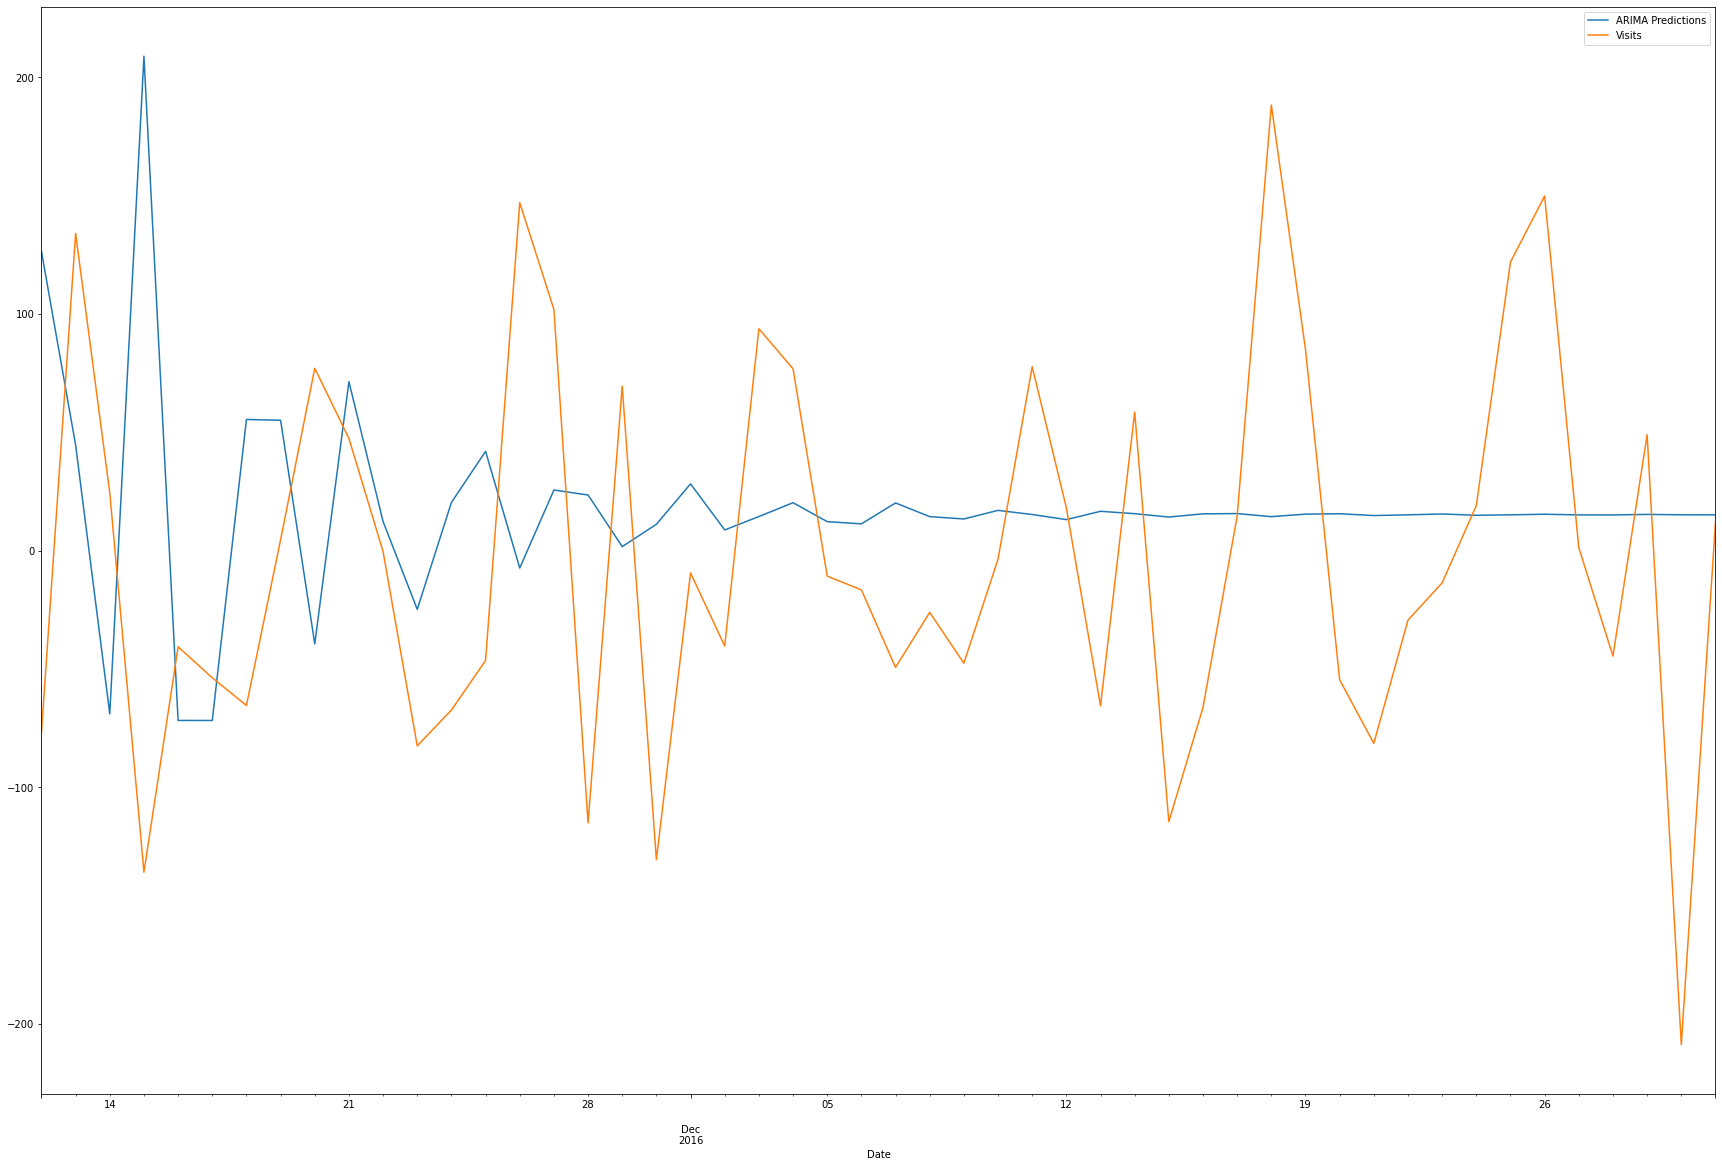

In [ ]:
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Visits'].plot(legend=True)

In [ ]:
# Metrics
test['Visits'].mean()
mae = mean_absolute_error(pred, test['Visits'])
mse = mean_squared_error(pred, test['Visits'])
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 76.99584798274198
Mean Squared Error: 9995.49922706475
Root Mean Squared Error: 99.97749360263414
